# packages

In [1]:
import pandas as pd
import quantstats as qs
import pickle
import re
import os
import numpy as np

In [108]:
df = pd.read_csv('../outputs_hhhl_ml1/before_good26_rest/ORCL/backtest/df_stats.csv')

In [109]:
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11
0,Start,2000-01-10 00:00:00,2006-06-19 00:00:00,2000-01-10 00:00:00,2009-07-17 00:00:00,2000-01-10 00:00:00,2012-08-08 00:00:00,2000-01-10 00:00:00,2015-09-15 00:00:00,2000-01-10 00:00:00,2018-08-29 00:00:00,2000-01-10 00:00:00,2021-07-15 00:00:00
1,End,2006-06-16 00:00:00,2009-07-16 00:00:00,2009-07-16 00:00:00,2012-08-07 00:00:00,2012-08-07 00:00:00,2015-09-14 00:00:00,2015-09-14 00:00:00,2018-08-28 00:00:00,2018-08-28 00:00:00,2021-07-12 00:00:00,2021-07-12 00:00:00,2024-10-10 00:00:00
2,Period,1618 days 00:00:00,775 days 00:00:00,2393 days 00:00:00,772 days 00:00:00,3165 days 00:00:00,779 days 00:00:00,3944 days 00:00:00,745 days 00:00:00,4689 days 00:00:00,721 days 00:00:00,5410 days 00:00:00,816 days 00:00:00
3,Start Value,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
4,End Value,290.77508190136484,242.1327157507496,3209.085046269844,306.1137161032776,3462.3753343410394,240.99195732631208,6015.343803012408,211.483926360233,8837.467898317822,230.3408712190465,88960.23579451621,546.3912384357037


# existing stats from pf.stats

In [110]:
def process_existing_stats(df_stats):
    df_stats = df_stats.set_index('Unnamed: 0')
    df_stats.index.name = None
    
    transformed_rows = []

    # Iterate over pairs of columns (train-test combinations)
    for i in range(0, df_stats.shape[1], 2):
        train_col = i
        test_col = i + 1
        
        # Create a dictionary to store values for the current combination
        row = {}
        
        # Set the combination number
        row['train_test_combination'] = i // 2
        
        # Add train and test statistics to the row with new column names
        for stat in df_stats.index:
            row[f'train_{stat.lower().replace(" ", "_")}'] = df_stats.loc[stat, str(train_col)]
            row[f'test_{stat.lower().replace(" ", "_")}'] = df_stats.loc[stat, str(test_col)]
        
        # Append the row to the transformed rows list
        transformed_rows.append(row)

    # Create a new DataFrame from the transformed rows
    df_transformed = pd.DataFrame(transformed_rows)
    excluded_columns = {'train_start', 'test_start', 'train_end', 'test_end', 'train_period', 'test_period'}
    for col in df_transformed.columns:
        if 'duration' not in col and col not in excluded_columns:
            df_transformed[col] = df_transformed[col].astype(float)
        elif (col in excluded_columns and 'period' in col) or ('duration' in col):
            # Convert period columns to float days
            df_transformed[col] = pd.to_timedelta(df_transformed[col]).dt.total_seconds() / (24 * 3600)
    
    return df_transformed

process_existing_stats(df)

,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,train_end_value,...,train_expectancy,test_expectancy,train_sharpe_ratio,test_sharpe_ratio,train_calmar_ratio,test_calmar_ratio,train_omega_ratio,test_omega_ratio,train_sortino_ratio,test_sortino_ratio
0,0.0,2000-01-10 00:00:00,2006-06-19 00:00:00,2006-06-16 00:00:00,2009-07-16 00:00:00,1618.0,775.0,100.0,100.0,290.775082,...,1.295368,3.384112,0.975684,0.980142,0.426440,1.747438,1.250014,1.329824,1.565967,1.576195
1,1.0,2000-01-10 00:00:00,2009-07-17 00:00:00,2009-07-16 00:00:00,2012-08-07 00:00:00,2393.0,772.0,100.0,100.0,3209.085046,...,22.932115,4.528574,1.106845,1.087510,1.464769,2.977417,1.300569,1.300668,1.773852,1.705708
2,2.0,2000-01-10 00:00:00,2012-08-08 00:00:00,2012-08-07 00:00:00,2015-09-14 00:00:00,3165.0,779.0,100.0,100.0,3462.375334,...,17.675559,2.660226,1.027141,0.934371,0.643946,2.646347,1.278662,1.269234,1.646453,1.471992
3,3.0,2000-01-10 00:00:00,2015-09-15 00:00:00,2015-09-14 00:00:00,2018-08-28 00:00:00,3944.0,745.0,100.0,100.0,6015.343803,...,20.183980,1.548388,0.992068,0.865236,0.711761,2.601962,1.268213,1.203659,1.569741,1.292896
4,4.0,2000-01-10 00:00:00,2018-08-29 00:00:00,2018-08-28 00:00:00,2021-07-12 00:00:00,4689.0,721.0,100.0,100.0,8837.467898,...,28.689557,1.780570,0.939279,0.958932,0.607345,3.048036,1.259467,1.221953,1.485741,1.477511
5,5.0,2000-01-10 00:00:00,2021-07-15 00:00:00,2021-07-12 00:00:00,2024-10-10 00:00:00,5410.0,816.0,100.0,100.0,88960.235795,...,223.869176,7.262950,0.987662,2.365588,1.082136,7.418604,1.281594,1.646318,1.568137,4.174921


# trend strength

In [111]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Example: Creating a sample time series data (you can replace this with your stock data)
dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
np.random.seed(42)
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()

# Create a DataFrame with the dates and prices
df_test = pd.DataFrame({'Date': dates, 'Price': price_data})
df_test.set_index('Date', inplace=True)

# Function to calculate the trend slope over the last 'window_size' observations
def calculate_trend_slope(train_start, train_end, test_start, test_end, window_size):
    series = pd.read_csv('../outputs_hhhl_ml1/before_good26_rest/ORCL/df_price.csv', index = 'Date')['Adj Close']
    if len(series) < window_size:
        raise ValueError(f"Series length is less than the window size {window_size}")
    
    # Extract the last 'window_size' observations
    y = series[-window_size:]
    x = np.arange(len(y))  # Time indices

    # Perform linear regression to calculate slope
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    return slope

# # Calculate the slope for different window sizes
# window_50 = calculate_trend_slope(df_test['Price'], window_size=50)
# window_200 = calculate_trend_slope(df_test['Price'], window_size=200)

# print(f"Trend slope for last 50 observations: {window_50}")
# print(f"Trend slope for last 200 observations: {window_200}")

# # Plot the data and trend line
# plt.plot(df_test.index, df_test['Price'], label='Price')

# # Overlay the trend line for the last 50 observations
# x_50 = np.arange(50)
# y_trend_50 = window_50 * x_50 + df_test['Price'][-50].mean()  # Adjust to match the series' mean
# plt.plot(df_test.index[-50:], y_trend_50, color='red', label='Trend (last 50)')

# # Overlay the trend line for the last 200 observations
# x_200 = np.arange(200)
# y_trend_200 = window_200 * x_200 + df_test['Price'][-200].mean()  # Adjust to match the series' mean
# plt.plot(df_test.index[-200:], y_trend_200, color='green', label='Trend (last 200)')

# plt.legend()
# plt.show()


# seasonal strength

In [112]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def calculate_seasonal_strength(series, window_size, period):
    
    # Get the last 'window_size' observations from the series
    series_window = series.tail(window_size)
    
    # Perform time series decomposition (additive model)
    result = seasonal_decompose(series_window, model='additive', period=period, extrapolate_trend='freq')

    # Extract the seasonal and residual components
    seasonal = result.seasonal
    residual = result.resid

    # Calculate variance of seasonal and residual components, ignoring NaNs
    seasonal_variance = np.nanvar(seasonal)
    residual_variance = np.nanvar(residual)
    
    # Normalize by the mean or standard deviation of the original series to account for magnitude
    mean_of_series = np.mean(series_window)

    if mean_of_series == 0 or (seasonal_variance + residual_variance) == 0:
        return 0  # Avoid division by zero

    # Calculate normalized seasonal strength: seasonal_variance / residual_variance, normalized by the mean of the series
    normalized_seasonal_strength = seasonal_variance / (seasonal_variance + residual_variance) / mean_of_series # maybe remove (/s var + res var)
    
    return normalized_seasonal_strength



# Example: Generating sample time series data (replace this with actual stock data)
dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
np.random.seed(42)
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()

# Create a DataFrame with the dates and prices
df_test = pd.DataFrame({'Date': dates, 'Price': price_data})
df_test.set_index('Date', inplace=True)

# Use the function to calculate seasonal strength for the last 200 days
window_size = 200
period = 30  # Monthly seasonality, 7 weekly, 365 yearly

seasonal_strength_value = calculate_seasonal_strength(df_test['Price'], window_size, period)

print(f"Seasonal strength for the last {window_size} days: {seasonal_strength_value:.4f}")


Seasonal strength for the last 200 days: 0.0016


# cyclical strength

In [113]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def calculate_cyclical_strength(series, window_size, period, moving_avg_window=30):
    """
    Calculate the normalized strength of the cyclical component of a time series over a given window.
    
    Parameters:
    series (pd.Series): The time series data.
    window_size (int): Number of observations to use for calculating the cyclical strength.
    period (int): The period of the cycle (e.g., 365 for annual cycles in daily data).
    moving_avg_window (int): Window size for the moving average to approximate the cyclical component.
    
    Returns:
    float: Normalized cyclical strength value.
    """
    
    # Get the last 'window_size' observations from the series
    series_window = pd.Series(series).tail(window_size)
    
    # Perform time series decomposition (additive model)
    result = seasonal_decompose(series_window, model='additive', period=period, extrapolate_trend='freq')

    # Extract the residual component (contains cyclical + noise components)
    residual = result.resid

    # Apply moving average to the residuals to approximate the cyclical component
    cyclical = residual.rolling(window=moving_avg_window, center=True).mean()

    # Calculate variance of the cyclical component and the residuals, ignoring NaNs
    cyclical_variance = np.nanvar(cyclical)
    residual_variance = np.nanvar(residual - cyclical)  # Noise component variance
    
    # Normalize by the mean of the original series to account for magnitude
    mean_of_series = np.mean(series_window)

    if mean_of_series == 0 or (cyclical_variance + residual_variance) == 0:
        return 0  # Avoid division by zero

    # Calculate normalized cyclical strength as a proportion of total variability
    normalized_cyclical_strength = (cyclical_variance / (cyclical_variance + residual_variance)) / mean_of_series
    
    return normalized_cyclical_strength


# Example usage with synthetic data (assuming 'series' and 'period' are predefined)
period = 365  # Assuming yearly seasonality for daily data
window = 30  # The window size for the moving average to remove short-term noise
window_size = 1000
cyclical_strength_value = calculate_cyclical_strength(price_data, window_size, period, window)

print(f"Cyclical Strength: {cyclical_strength_value}")


Cyclical Strength: 0.019642711876708036


# noise strength

In [114]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def calculate_noise_strength(series, window_size, period):
    """
    Calculate the normalized strength of the noise (residual) component of a time series over a given window.
    
    Parameters:
    series (pd.Series): The time series data.
    window_size (int): Number of observations to use for calculating the noise strength.
    period (int): The period of the seasonality (e.g., 365 for yearly seasonality on daily data).
    
    Returns:
    float: Normalized noise strength value.
    """
    
    # Get the last 'window_size' observations from the series
    series_window = series.tail(window_size)
    
    # Perform time series decomposition (additive model)
    result = seasonal_decompose(series_window, model='additive', period=period, extrapolate_trend='freq')

    # Extract the seasonal and residual components
    seasonal = result.seasonal
    residual = result.resid

    # Calculate variance of seasonal and residual components, ignoring NaNs
    residual_variance = np.nanvar(residual)
    
    # Normalize by the mean of the original series to account for magnitude
    mean_of_series = np.mean(series_window)

    # Avoid division by zero
    if mean_of_series == 0 or residual_variance == 0:
        return 0

    # Calculate normalized noise strength
    normalized_noise_strength = residual_variance / mean_of_series
    
    return normalized_noise_strength

# Example usage: 
dates = pd.date_range(start='2020-01-01', periods=1000, freq='D')
np.random.seed(42)
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()

df_test = pd.DataFrame({'Date': dates, 'Price': price_data})
df_test.set_index('Date', inplace=True)

window_size = 200
period = 30  # Set an appropriate period based on data frequency

noise_strength_value = calculate_noise_strength(df_test['Price'], window_size, period)
print(f"Noise strength for the last {window_size} days: {noise_strength_value:.4f}")


Noise strength for the last 200 days: 0.0484


# fractal efficiency

In [115]:
import numpy as np
import pandas as pd

def calculate_overall_efficiency_ratio(series, window):
    """
    Calculate the overall Efficiency Ratio (Fractal Efficiency) of a time series.
    
    Parameters:
    series (pd.Series): The time series data.
    
    Returns:
    float: Efficiency Ratio for the entire series.
    """
    series_window = pd.Series(series).tail(window)
    # Calculate the Net Change over the entire series
    net_change = abs(series_window.iloc[-1] - series_window.iloc[0])
    
    # Calculate the Total Change across all points in the series
    total_change = series_window.diff().abs().sum()
    
    # Calculate the Efficiency Ratio
    if total_change == 0:  # Avoid division by zero
        return 0
    
    efficiency_ratio = net_change / total_change
    return efficiency_ratio

# Example usage
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)

# Calculate the Efficiency Ratio for the entire series
overall_efficiency_ratio = calculate_overall_efficiency_ratio(series, 50)
print(f"Overall Efficiency Ratio: {overall_efficiency_ratio:.4f}")


Overall Efficiency Ratio: 0.0084


# current price as % of max

In [116]:
def calculate_percent_of_max(series):
    s_max = series.max()
    perc_of_max = series.tail(1)[0]/s_max
    
    return perc_of_max

# Example usage
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)

perc_of_max = calculate_percent_of_max(series)
print(f"Last price percent of overall max price: {perc_of_max:.4f}")

Last price percent of overall max price: 0.9063


# max drawdown & max drawdown duration of price

In [117]:
def calculate_max_drawdown(series):
    s = series.pct_change()
    max_drawdown = qs.stats.max_drawdown(s)
    cummax = (1 + s).cumprod().cummax()
    max_drawdown_duration = cummax.value_counts().head(1).iloc[0]/len(series)
    
    return max_drawdown, max_drawdown_duration

dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)

max_d, max_d_dur = calculate_max_drawdown(series)
print(f"Price max drawdown: {max_d:.4f}")
print(f"Price max drawdown duration as % of whole period: {max_d_dur}")

Price max drawdown: -0.1392
Price max drawdown duration as % of whole period: 0.61


# standard deviation of price

In [118]:
def calculate_std(series):
    std = series.std()/series.mean()
    return std

dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)

std = calculate_std(series)
print(f"Price standard deviation: {std:.4f}")

Price standard deviation: 0.0843


# desc stats of number of days between trades

In [119]:
def calculate_period_without_trades(df_trades):
    df_trades['exit_ts_shift'] = df_trades['Exit Timestamp'].shift(1)
    period_length = (df_trades['Exit Timestamp'].max() - df_trades['Entry Timestamp'].min()).days
    df_trades['days_between_trade'] = ((df_trades['Entry Timestamp'] - df_trades['exit_ts_shift']).dt.days)/period_length
    min_days = df_trades['days_between_trade'].min()
    max_days = df_trades['days_between_trade'].max()
    mean_days = df_trades['days_between_trade'].mean()
    std_days = df_trades['days_between_trade'].std()    
    
    return min_days, max_days, mean_days, std_days

df_trades = pd.read_csv('../outputs_hhhl_ml1/before_good26_rest/ORCL/backtest/train_0_trades.csv')
df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)

desc_days_trades = calculate_period_without_trades(df_trades)
print(desc_days_trades)

(0.00043687199650502403, 0.027959807776321538, 0.004621645857763674, 0.006057585335997416)


# desc of trades per month

In [120]:
def calculate_trades_per_period(df_trades):
    df_trades.set_index('Entry Timestamp', inplace = True)
    df_g = df_trades.resample('M')['PnL'].count()
    min_trades = df_g.min()
    max_trades = df_g.max()
    mean_trades = df_g.mean()
    std_trades = df_g.std()
    return min_trades, max_trades, mean_trades, std_trades

df_trades = pd.read_csv('../outputs_hhhl_ml1/before_good26_rest/ORCL/backtest/train_0_trades.csv')
df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)

calculate_trades_per_period(df_trades)

(0, 5, 1.763157894736842, 1.220583697008734)

# desc of trades returns

In [121]:
def calculate_trades_returns(df_trades):
    min_trades = df_trades['Return'].min()
    max_trades = df_trades['Return'].max()
    mean_trades = df_trades['Return'].mean()
    std_trades = df_trades['Return'].std()
    
    return min_trades, max_trades, mean_trades, std_trades

df_trades = pd.read_csv('../outputs_hhhl_ml1/before_good26_rest/ORCL/backtest/train_0_trades.csv')
df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)

calculate_trades_returns(df_trades)

(-0.2761519761776835,
 0.2499999999999999,
 0.011366545607989977,
 0.07980345577870791)

# perc of current drawdown period from max drawdown period

In [122]:
def calculate_perc_drawdown_period(series):
    s = series.pct_change()
    cummax = (1 + s).cumprod().cummax()
    max_drawdown_duration = cummax.value_counts().head(1).iloc[0]
    current_drawdown_duration = (cummax == cummax.tail(1)[0]).sum()
    return current_drawdown_duration/max_drawdown_duration

dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)

perc_drawdown_duration = calculate_perc_drawdown_period(series)
perc_drawdown_duration
    

0.05555555555555555

# correlation of cumulative returns with price

In [123]:
def calculate_price_returns_corr(series, df_trades):
    returns = df_trades['Return']
    returns.index = df_trades['Exit Timestamp']
    df = pd.concat([series, (returns + 1).cumprod()], axis = 1)
    df.iloc[0, 1] = 1
    df.ffill(inplace = True)
    corr = df.corr().iloc[0,1]
    return corr, df

dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)
df_trades = pd.DataFrame({'Return': np.random.rand(len(dates)), 'Exit Timestamp': dates})

corr, df_out = calculate_price_returns_corr(series, df_trades)
corr

-0.4697479615044177

# desc stats of rolling correlation of returns and price

In [124]:
def calculate_price_returns_rolling_corr(series, df_trades, window):
    returns = df_trades['Return']
    returns.index = df_trades['Exit Timestamp']
    df = pd.concat([series, (returns + 1).cumprod()], axis = 1)
    df.iloc[0, 1] = 1
    df.ffill(inplace = True)
    price = df.iloc[:, 0]
    trades_returns = df.iloc[:, 1]
    rolling_corr = price.rolling(window = window).corr(trades_returns).dropna()
    min_corr = rolling_corr.min()
    max_corr = rolling_corr.max()
    mean_corr = rolling_corr.mean()
    std_corr = rolling_corr.std()
    return min_corr, max_corr, mean_corr, std_corr

dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)
df_trades = pd.DataFrame({'Return': np.random.rand(len(dates)), 'Exit Timestamp': dates})

t = calculate_price_returns_rolling_corr(series, df_trades, 10)
t

(-0.7456334463291172,
 0.9526217962634782,
 0.3283485567919696,
 0.5163894125931645)

# outlier counts in trades returns

In [125]:
def calculate_outlier_cnts(df_trades, threshold):
    outliers_cnt = (df_trades['Return'] <= threshold).sum()
    return outliers_cnt/len(df_trades)

dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
price_data = 50 + np.random.normal(0, 1, len(dates)).cumsum()
series = pd.Series(price_data, index=dates)
df_trades = pd.DataFrame({'Return': np.random.rand(len(dates)), 'Exit Timestamp': dates})

calculate_outlier_cnts(df_trades, -0.05)

0.0

# model train stats

In [126]:
def get_class_report(report):
    pattern = r'(\b(?:False|True|accuracy|macro avg|weighted avg)\b)\s+([\d.]*)\s+([\d.]+)\s+([\d.]+)'
    matches = re.findall(pattern, report)

    # Create dictionary to store metrics
    metrics_dict = {}

    for match in matches:
        label, precision, recall, f1_score = match
        if label == 'accuracy':  # Only one value for accuracy
            metrics_dict[label] = float(recall)
        else:
            if precision:  # Ignore empty precision values for rows without it
                metrics_dict[f"{label}_precision"] = float(precision)
            metrics_dict[f"{label}_recall"] = float(recall)
            metrics_dict[f"{label}_f1_score"] = float(f1_score)
    return metrics_dict
train_stuff = pickle.load(open('../outputs_hhhl_ml1/before_good26_rest/ORCL/train_stuff.pickle', 'rb'))
report = train_stuff['train_class_reports'][0]
get_class_report(report)

{'False_precision': 0.99,
 'False_recall': 0.97,
 'False_f1_score': 0.98,
 'True_precision': 0.94,
 'True_recall': 0.98,
 'True_f1_score': 0.96,
 'accuracy': 0.97,
 'macro avg_precision': 0.96,
 'macro avg_recall': 0.97,
 'macro avg_f1_score': 0.97,
 'weighted avg_precision': 0.97,
 'weighted avg_recall': 0.97,
 'weighted avg_f1_score': 0.97}

# dataset build

In [13]:
experiment_name = 'before_good26_rest'
experiment_path = f"../outputs_hhhl_ml1/{experiment_name}"

symbols = [name for name in os.listdir(experiment_path) if os.path.isdir(os.path.join(experiment_path, name))]

In [128]:
list_symbols_dfs = []

for symbol in symbols:
    symbol_path = f"{experiment_path}/{symbol}"
    df_stats = pd.read_csv(f"{symbol_path}/backtest/df_stats.csv")
    df_symbol = process_existing_stats(df_stats)
    df_symbol['symbol'] = symbol
    colnames = [df_symbol.columns[-1]] + list(df_symbol.columns[:-1])
    df_symbol = df_symbol[colnames]
    list_symbols_dfs.append(df_symbol)
df = pd.concat(list_symbols_dfs, axis =0)

In [129]:
df.shape

(1052, 58)

In [130]:
df.head(10)

,symbol,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,...,train_expectancy,test_expectancy,train_sharpe_ratio,test_sharpe_ratio,train_calmar_ratio,test_calmar_ratio,train_omega_ratio,test_omega_ratio,train_sortino_ratio,test_sortino_ratio
0,TJX,0.0,2000-01-07 00:00:00,2006-08-07 00:00:00,2006-08-04 00:00:00,2010-01-27 00:00:00,1653.0,875.0,100.0,100.0,...,6.654207,2.855433,1.274314,0.657814,1.879271,0.933827,1.343739,1.337054,2.098648,1.044396
1,TJX,1.0,2000-01-07 00:00:00,2010-01-28 00:00:00,2010-01-27 00:00:00,2012-11-29 00:00:00,2528.0,716.0,100.0,100.0,...,16.243531,2.866706,1.220968,1.141061,2.072756,3.707172,1.339096,1.280292,1.997439,1.792124
2,TJX,2.0,2000-01-07 00:00:00,2012-11-30 00:00:00,2012-11-29 00:00:00,2016-01-25 00:00:00,3244.0,792.0,100.0,100.0,...,56.706777,0.869280,1.178688,0.747883,2.326982,1.059748,1.334222,1.176476,1.927009,1.124046
3,TJX,3.0,2000-01-07 00:00:00,2016-01-26 00:00:00,2016-01-25 00:00:00,2019-02-12 00:00:00,4036.0,768.0,100.0,100.0,...,137.488440,1.802699,1.130173,0.751539,2.269650,2.176509,1.326110,1.187576,1.839687,1.130974
4,TJX,4.0,2000-01-07 00:00:00,2019-02-13 00:00:00,2019-02-12 00:00:00,2021-12-27 00:00:00,4804.0,724.0,100.0,100.0,...,169.810563,1.601596,1.048429,0.921876,1.858248,2.395654,1.312682,1.179903,1.698057,1.374492
5,TJX,5.0,2000-01-07 00:00:00,2021-12-28 00:00:00,2021-12-27 00:00:00,2024-10-17 00:00:00,5528.0,706.0,100.0,100.0,...,409.687788,1.725069,1.025770,1.419325,1.954004,3.024418,1.310984,1.335233,1.667681,2.168212
0,ZTS,0.0,2013-02-06 00:00:00,2018-08-02 00:00:00,2018-08-01 00:00:00,2021-05-28 00:00:00,1382.0,711.0,100.0,100.0,...,3.517477,2.053002,1.052592,1.298221,2.405298,4.799122,1.238280,1.334131,1.570554,2.099449
1,ZTS,1.0,2013-02-06 00:00:00,2021-06-01 00:00:00,2021-05-28 00:00:00,2024-10-17 00:00:00,2093.0,852.0,100.0,100.0,...,6.895038,2.595950,1.172641,1.889017,2.529929,4.206680,1.262204,1.427613,1.755537,3.193254
0,CSX,0.0,2000-01-07 00:00:00,2006-08-04 00:00:00,2006-08-03 00:00:00,2009-11-09 00:00:00,1652.0,823.0,100.0,100.0,...,13.738321,6.089717,1.499536,1.592117,2.247327,2.529441,1.475021,1.383238,2.634410,2.648810
1,CSX,1.0,2000-01-07 00:00:00,2009-11-10 00:00:00,2009-11-09 00:00:00,2012-11-27 00:00:00,2475.0,767.0,100.0,100.0,...,45.785562,4.555247,1.411191,0.994682,1.532272,2.078037,1.444509,1.362127,2.447735,1.617255


In [131]:
def calculate_trend_slope(train_start, train_end, symbol, experiment_name, window_size):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    if len(series) < window_size:
        raise ValueError(f"Series length is less than the window size {window_size}")
    
    # Extract the last 'window_size' observations
    y = series[-window_size:]
    x = np.arange(len(y))  # Time indices

    # Perform linear regression to calculate slope
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    return slope
df['train_slope_250'] = df.apply(lambda row:calculate_trend_slope(row['train_start'], row['train_end'],
                                          row['symbol'], experiment_name, 250), axis = 'columns')
df['train_slope_100'] = df.apply(lambda row:calculate_trend_slope(row['train_start'], row['train_end'],
                                          row['symbol'], experiment_name, 100), axis = 'columns')
df['train_slope_50'] = df.apply(lambda row:calculate_trend_slope(row['train_start'], row['train_end'],
                                          row['symbol'], experiment_name, 50), axis = 'columns')
df['train_slope_20'] = df.apply(lambda row:calculate_trend_slope(row['train_start'], row['train_end'],
                                          row['symbol'], experiment_name, 20), axis = 'columns')

In [132]:
def calculate_seasonal_strength(train_start, train_end, symbol, experiment_name, window_size, period):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    if window_size:
        series_window = series.tail(window_size)
    else:
        series_window = series
    result = seasonal_decompose(series_window, model='additive', period=period, extrapolate_trend='freq')
    seasonal = result.seasonal
    residual = result.resid
    seasonal_variance = np.nanvar(seasonal)
    residual_variance = np.nanvar(residual)
    mean_of_series = np.mean(series_window)

    if mean_of_series == 0 or (seasonal_variance + residual_variance) == 0:
        return 0  # Avoid division by zero

    normalized_seasonal_strength = seasonal_variance / (seasonal_variance + residual_variance) / mean_of_series # maybe remove (/s var + res var)
    
    return normalized_seasonal_strength

df['train_seasonal_strength_all_30'] = df.apply(lambda row:calculate_seasonal_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None,
                                                                                    30), 
                                                axis = 'columns')
df['train_seasonal_strength_all_7'] = df.apply(lambda row:calculate_seasonal_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None,
                                                                                    7), 
                                                axis = 'columns')
df['train_seasonal_strength_1y_30'] = df.apply(lambda row:calculate_seasonal_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250,
                                                                                    30), 
                                                axis = 'columns')
df['train_seasonal_strength_1y_7'] = df.apply(lambda row:calculate_seasonal_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250,
                                                                                    7), 
                                                axis = 'columns')

In [133]:
df.to_csv('../data/df_train_test_combs.csv', index = False, header = True)

In [134]:
df = pd.read_csv('../data/df_train_test_combs.csv')

In [135]:
df.head()

,symbol,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,...,train_sortino_ratio,test_sortino_ratio,train_slope_250,train_slope_100,train_slope_50,train_slope_20,train_seasonal_strength_all_30,train_seasonal_strength_all_7,train_seasonal_strength_1y_30,train_seasonal_strength_1y_7
0,TJX,0.0,2000-01-07 00:00:00,2006-08-07 00:00:00,2006-08-04 00:00:00,2010-01-27 00:00:00,1653.0,875.0,100.0,100.0,...,2.098648,1.044396,0.002756,-0.002667,0.007090,0.015246,0.002305,0.001010,0.020462,0.008107
1,TJX,1.0,2000-01-07 00:00:00,2010-01-28 00:00:00,2010-01-27 00:00:00,2012-11-29 00:00:00,2528.0,716.0,100.0,100.0,...,1.997439,1.792124,0.015681,0.000486,-0.005656,0.007873,0.001074,0.000352,0.034292,0.005128
2,TJX,2.0,2000-01-07 00:00:00,2012-11-30 00:00:00,2012-11-29 00:00:00,2016-01-25 00:00:00,3244.0,792.0,100.0,100.0,...,1.927009,1.124046,0.024224,-0.011919,-0.024633,0.070955,0.001343,0.000313,0.011229,0.003238
3,TJX,3.0,2000-01-07 00:00:00,2016-01-26 00:00:00,2016-01-25 00:00:00,2019-02-12 00:00:00,4036.0,768.0,100.0,100.0,...,1.839687,1.130974,0.009027,-0.010845,-0.002406,-0.092302,0.000374,0.000404,0.005329,0.000967
4,TJX,4.0,2000-01-07 00:00:00,2019-02-13 00:00:00,2019-02-12 00:00:00,2021-12-27 00:00:00,4804.0,724.0,100.0,100.0,...,1.698057,1.374492,0.041044,-0.096869,0.086110,0.061747,0.000220,0.000175,0.000893,0.000275


In [136]:
def calculate_cyclical_strength(train_start, train_end, symbol, experiment_name, window_size, period, moving_avg_window=30):
    """
    Calculate the normalized strength of the cyclical component of a time series over a given window.
    
    Parameters:
    series (pd.Series): The time series data.
    window_size (int): Number of observations to use for calculating the cyclical strength.
    period (int): The period of the cycle (e.g., 365 for annual cycles in daily data).
    moving_avg_window (int): Window size for the moving average to approximate the cyclical component.
    
    Returns:
    float: Normalized cyclical strength value.
    """
    
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    if window_size:
        series_window = series.tail(window_size)
    else:
        series_window = series
    
    # Perform time series decomposition (additive model)
    result = seasonal_decompose(series_window, model='additive', period=period, extrapolate_trend='freq')

    # Extract the residual component (contains cyclical + noise components)
    residual = result.resid

    # Apply moving average to the residuals to approximate the cyclical component
    cyclical = residual.rolling(window=moving_avg_window, center=True).mean()

    # Calculate variance of the cyclical component and the residuals, ignoring NaNs
    cyclical_variance = np.nanvar(cyclical)
    residual_variance = np.nanvar(residual - cyclical)  # Noise component variance
    
    # Normalize by the mean of the original series to account for magnitude
    mean_of_series = np.mean(series_window)

    if mean_of_series == 0 or (cyclical_variance + residual_variance) == 0:
        return 0  # Avoid division by zero

    # Calculate normalized cyclical strength as a proportion of total variability
    normalized_cyclical_strength = (cyclical_variance / (cyclical_variance + residual_variance)) / mean_of_series
    
    return normalized_cyclical_strength

df['train_cyclical_strength_all_30'] = df.apply(lambda row:calculate_cyclical_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None,
                                                                                    30), 
                                                axis = 'columns')
df['train_cyclical_strength_all_7'] = df.apply(lambda row:calculate_cyclical_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None,
                                                                                    7,
                                                                                    7), 
                                                axis = 'columns')
df['train_cyclical_strength_1y_30'] = df.apply(lambda row:calculate_cyclical_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250,
                                                                                    30), 
                                                axis = 'columns')
df['train_cyclical_strength_1y_7'] = df.apply(lambda row:calculate_cyclical_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250,
                                                                                    7,
                                                                                    7), 
                                                axis = 'columns')

In [137]:
df.head()

,symbol,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,...,train_slope_50,train_slope_20,train_seasonal_strength_all_30,train_seasonal_strength_all_7,train_seasonal_strength_1y_30,train_seasonal_strength_1y_7,train_cyclical_strength_all_30,train_cyclical_strength_all_7,train_cyclical_strength_1y_30,train_cyclical_strength_1y_7
0,TJX,0.0,2000-01-07 00:00:00,2006-08-07 00:00:00,2006-08-04 00:00:00,2010-01-27 00:00:00,1653.0,875.0,100.0,100.0,...,0.007090,0.015246,0.002305,0.001010,0.020462,0.008107,0.018082,0.020867,0.012569,0.016994
1,TJX,1.0,2000-01-07 00:00:00,2010-01-28 00:00:00,2010-01-27 00:00:00,2012-11-29 00:00:00,2528.0,716.0,100.0,100.0,...,-0.005656,0.007873,0.001074,0.000352,0.034292,0.005128,0.011869,0.016063,0.006434,0.011182
2,TJX,2.0,2000-01-07 00:00:00,2012-11-30 00:00:00,2012-11-29 00:00:00,2016-01-25 00:00:00,3244.0,792.0,100.0,100.0,...,-0.024633,0.070955,0.001343,0.000313,0.011229,0.003238,0.008606,0.010083,0.002960,0.003151
3,TJX,3.0,2000-01-07 00:00:00,2016-01-26 00:00:00,2016-01-25 00:00:00,2019-02-12 00:00:00,4036.0,768.0,100.0,100.0,...,-0.002406,-0.092302,0.000374,0.000404,0.005329,0.000967,0.004765,0.006648,0.001120,0.002257
4,TJX,4.0,2000-01-07 00:00:00,2019-02-13 00:00:00,2019-02-12 00:00:00,2021-12-27 00:00:00,4804.0,724.0,100.0,100.0,...,0.086110,0.061747,0.000220,0.000175,0.000893,0.000275,0.004904,0.005346,0.002397,0.002400


In [138]:
def calculate_noise_strength(train_start, train_end, symbol, experiment_name, window_size, period):
    """
    Calculate the normalized strength of the noise (residual) component of a time series over a given window.
    
    Parameters:
    series (pd.Series): The time series data.
    window_size (int): Number of observations to use for calculating the noise strength.
    period (int): The period of the seasonality (e.g., 365 for yearly seasonality on daily data).
    
    Returns:
    float: Normalized noise strength value.
    """
    
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    if window_size:
        series_window = series.tail(window_size)
    else:
        series_window = series
    
    # Perform time series decomposition (additive model)
    result = seasonal_decompose(series_window, model='additive', period=period, extrapolate_trend='freq')

    # Extract the seasonal and residual components
    seasonal = result.seasonal
    residual = result.resid

    # Calculate variance of seasonal and residual components, ignoring NaNs
    residual_variance = np.nanvar(residual)
    
    # Normalize by the mean of the original series to account for magnitude
    mean_of_series = np.mean(series_window)

    # Avoid division by zero
    if mean_of_series == 0 or residual_variance == 0:
        return 0

    # Calculate normalized noise strength
    normalized_noise_strength = residual_variance / mean_of_series
    
    return normalized_noise_strength

df['train_noise_strength_all_30'] = df.apply(lambda row:calculate_noise_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None,
                                                                                    30), 
                                                axis = 'columns')
df['train_noise_strength_all_7'] = df.apply(lambda row:calculate_noise_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None,
                                                                                    7), 
                                                axis = 'columns')
df['train_noise_strength_1y_30'] = df.apply(lambda row:calculate_noise_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250,
                                                                                    30), 
                                                axis = 'columns')
df['train_noise_strength_1y_7'] = df.apply(lambda row:calculate_noise_strength(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250,
                                                                                    7), 
                                                axis = 'columns')

In [139]:
df.head()

,symbol,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,...,train_seasonal_strength_1y_30,train_seasonal_strength_1y_7,train_cyclical_strength_all_30,train_cyclical_strength_all_7,train_cyclical_strength_1y_30,train_cyclical_strength_1y_7,train_noise_strength_all_30,train_noise_strength_all_7,train_noise_strength_1y_30,train_noise_strength_1y_7
0,TJX,0.0,2000-01-07 00:00:00,2006-08-07 00:00:00,2006-08-04 00:00:00,2010-01-27 00:00:00,1653.0,875.0,100.0,100.0,...,0.020462,0.008107,0.018082,0.020867,0.012569,0.016994,0.003266,0.000746,0.002173,0.000487
1,TJX,1.0,2000-01-07 00:00:00,2010-01-28 00:00:00,2010-01-27 00:00:00,2012-11-29 00:00:00,2528.0,716.0,100.0,100.0,...,0.034292,0.005128,0.011869,0.016063,0.006434,0.011182,0.003913,0.001099,0.003438,0.001444
2,TJX,2.0,2000-01-07 00:00:00,2012-11-30 00:00:00,2012-11-29 00:00:00,2016-01-25 00:00:00,3244.0,792.0,100.0,100.0,...,0.011229,0.003238,0.008606,0.010083,0.002960,0.003151,0.004609,0.001295,0.005662,0.001705
3,TJX,3.0,2000-01-07 00:00:00,2016-01-26 00:00:00,2016-01-25 00:00:00,2019-02-12 00:00:00,4036.0,768.0,100.0,100.0,...,0.005329,0.000967,0.004765,0.006648,0.001120,0.002257,0.006438,0.001950,0.009533,0.003646
4,TJX,4.0,2000-01-07 00:00:00,2019-02-13 00:00:00,2019-02-12 00:00:00,2021-12-27 00:00:00,4804.0,724.0,100.0,100.0,...,0.000893,0.000275,0.004904,0.005346,0.002397,0.002400,0.010295,0.002484,0.027465,0.004589


In [140]:
df.to_csv('../data/df_train_test_combs.csv', index = False, header = True)

In [141]:
df = pd.read_csv('../data/df_train_test_combs.csv')

In [142]:
def calculate_overall_efficiency_ratio(train_start, train_end, symbol, experiment_name, window):
    """
    Calculate the overall Efficiency Ratio (Fractal Efficiency) of a time series.
    
    Parameters:
    series (pd.Series): The time series data.
    
    Returns:
    float: Efficiency Ratio for the entire series.
    """
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    if window_size:
        series_window = series.tail(window_size)
    else:
        series_window = series
        
    # Calculate the Net Change over the entire series
    net_change = abs(series_window.iloc[-1] - series_window.iloc[0])
    
    # Calculate the Total Change across all points in the series
    total_change = series_window.diff().abs().sum()
    
    # Calculate the Efficiency Ratio
    if total_change == 0:  # Avoid division by zero
        return 0
    
    efficiency_ratio = net_change / total_change
    return efficiency_ratio

df['train_fract_efficiency_all'] = df.apply(lambda row:calculate_overall_efficiency_ratio(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    None), 
                                                axis = 'columns')
df['train_fract_efficiency_250'] = df.apply(lambda row:calculate_overall_efficiency_ratio(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    250), 
                                                axis = 'columns')
df['train_fract_efficiency_100'] = df.apply(lambda row:calculate_overall_efficiency_ratio(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    100), 
                                                axis = 'columns')

In [143]:
def calculate_percent_of_max(train_start, train_end, symbol, experiment_name):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    s_max = series.max()
    perc_of_max = series.tail(1)[0]/s_max
    
    return perc_of_max

df['train_price_perc_from_max'] = df.apply(lambda row: calculate_percent_of_max(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name),
                                           axis = 'columns')

In [144]:
def calculate_max_drawdown(train_start, train_end, symbol, experiment_name):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    
    s = series.pct_change()
    max_drawdown = qs.stats.max_drawdown(s)
    cummax = (1 + s).cumprod().cummax()
    max_drawdown_duration = cummax.value_counts().head(1).iloc[0]/len(series)
    
    return max_drawdown, max_drawdown_duration

df[['train_max_drawdown', 'train_max_drawdown_duration']] = df.apply(lambda row: pd.Series(calculate_max_drawdown(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name)),
                                           axis = 'columns')

In [145]:
def calculate_std(train_start, train_end, symbol, experiment_name):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    
    std = series.std()/series.mean()
    return std

df['train_price_std'] = df.apply(lambda row: calculate_std(row['train_start'], 
                                                            row['train_end'],
                                                            row['symbol'], 
                                                            experiment_name),
                                           axis = 'columns')

In [146]:
def calculate_period_without_trades(symbol, experiment_name, train_test_comb):
    df_trades = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/backtest/train_{int(train_test_comb)}_trades.csv")
    df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)
    
    df_trades['exit_ts_shift'] = df_trades['Exit Timestamp'].shift(1)
    period_length = (df_trades['Exit Timestamp'].max() - df_trades['Entry Timestamp'].min()).days
    df_trades['days_between_trade'] = ((df_trades['Entry Timestamp'] - df_trades['exit_ts_shift']).dt.days)/period_length
    min_days = df_trades['days_between_trade'].min()
    max_days = df_trades['days_between_trade'].max()
    mean_days = df_trades['days_between_trade'].mean()
    std_days = df_trades['days_between_trade'].std()    
    
    return min_days, max_days, mean_days, std_days

df[['train_period_wo_trades_min', 'train_period_wo_trades_max', \
    'train_period_wo_trades_mean', 'train_period_wo_trades_std']] = df.apply(lambda row: pd.Series(calculate_period_without_trades(
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    int(row['train_test_combination']))),
                                                                axis = 'columns')


In [147]:
def calculate_trades_per_period(symbol, experiment_name, train_test_comb):
    df_trades = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/backtest/train_{int(train_test_comb)}_trades.csv")
    df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)
    
    df_trades.set_index('Entry Timestamp', inplace = True)
    df_g = df_trades.resample('M')['PnL'].count()
    min_trades = df_g.min()
    max_trades = df_g.max()
    mean_trades = df_g.mean()
    std_trades = df_g.std()
    return min_trades, max_trades, mean_trades, std_trades

df[['train_trades_per_period_min', 'train_trades_per_period_max', \
    'train_trades_per_period_mean', 'train_trades_per_period_std']] = df.apply(lambda row: pd.Series(calculate_trades_per_period(
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    int(row['train_test_combination']))),
                                                                axis = 'columns')

In [148]:
def calculate_trades_returns(symbol, experiment_name, train_test_comb):
    df_trades = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/backtest/train_{int(train_test_comb)}_trades.csv")
    df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)
    
    min_trades = df_trades['Return'].min()
    max_trades = df_trades['Return'].max()
    mean_trades = df_trades['Return'].mean()
    std_trades = df_trades['Return'].std()
    
    return min_trades, max_trades, mean_trades, std_trades

df[['train_trades_returns_min', 'train_trades_returns_max', \
    'train_trades_returns_mean', 'train_trades_returns_std']] = df.apply(lambda row: pd.Series(calculate_trades_returns(
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    int(row['train_test_combination']))),
                                                                axis = 'columns')

In [149]:
def calculate_perc_drawdown_period(train_start, train_end, symbol, experiment_name):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    
    s = series.pct_change()
    cummax = (1 + s).cumprod().cummax()
    max_drawdown_duration = cummax.value_counts().head(1).iloc[0]
    current_drawdown_duration = (cummax == cummax.tail(1)[0]).sum()
    return current_drawdown_duration/max_drawdown_duration

df['train_perc_drawd_per'] = df.apply(lambda row:calculate_perc_drawdown_period(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name), 
                                                axis = 'columns')

In [150]:
def calculate_price_returns_corr(train_start, train_end, symbol, experiment_name, train_test_comb):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                         index_col = 'Date')['Adj Close']
    series = series[train_start:train_end]
    df_trades = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/backtest/train_{int(train_test_comb)}_trades.csv")
    df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)
    
    returns = df_trades['Return']
    returns.index = df_trades['Exit Timestamp']
    df = pd.concat([series, (returns + 1).cumprod()], axis = 1)
    df.iloc[0, 1] = 1
    df.ffill(inplace = True)
    corr = df.corr().iloc[0,1]
    return corr

df['train_price_returns_corr'] = df.apply(lambda row:calculate_price_returns_corr(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    row['train_test_combination']), 
                                                axis = 'columns')

In [27]:
def calculate_price_returns_rolling_corr(train_start, train_end, symbol, experiment_name, train_test_comb, window):
    series = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/df_price.csv", 
                        index_col='Date', parse_dates=True)['Adj Close']
    series = series[train_start:train_end]

    # Load trade data
    df_trades = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/backtest/train_{int(train_test_comb)}_trades.csv")
    df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)

    # Prepare cumulative returns
    returns = df_trades['Return']
    returns.index = df_trades['Exit Timestamp']
    returns.index = returns.index.floor('D')  # Align index to daily format
    cumulative_returns = (returns + 1).cumprod()

    # Combine and align series
    df = pd.concat([series, cumulative_returns], axis=1)
    df.iloc[0, 1] = 1
    df.ffill(inplace=True)  # Handle missing data

    # Calculate rolling correlation
    rolling_corr = df['Adj Close'].rolling(window=window).corr(df['Return']).replace([np.inf, -np.inf], np.nan).dropna()
    min_corr = rolling_corr.min()
    max_corr = rolling_corr.max()
    mean_corr = rolling_corr.mean()
    std_corr = rolling_corr.std()

    return min_corr, max_corr, mean_corr, std_corr

df[['train_price_returns_corr_rol10_min', 'train_price_returns_corr_rol10_max', \
    'train_price_returns_corr_rol10_mean', 'train_price_returns_corr_rol10_std']] = df.apply(lambda row:pd.Series(calculate_price_returns_rolling_corr(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    row['train_test_combination'],
                                                                                    10)), 
                                                axis = 'columns')
df[['train_price_returns_corr_rol30_min', 'train_price_returns_corr_rol30_max', \
    'train_price_returns_corr_rol30_mean', 'train_price_returns_corr_rol30_std']] = df.apply(lambda row:pd.Series(calculate_price_returns_rolling_corr(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    row['train_test_combination'],
                                                                                    30)), 
                                                axis = 'columns')
df[['train_price_returns_corr_rol90_min', 'train_price_returns_corr_rol90_max', \
    'train_price_returns_corr_rol90_mean', 'train_price_returns_corr_rol90_std']] = df.apply(lambda row:pd.Series(calculate_price_returns_rolling_corr(row['train_start'], 
                                                                                    row['train_end'],
                                                                                    row['symbol'], 
                                                                                    experiment_name,
                                                                                    row['train_test_combination'],
                                                                                    90)), 
                                                axis = 'columns')

In [152]:
def calculate_outlier_cnts(symbol, experiment_name, train_test_comb, threshold):
    df_trades = pd.read_csv(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/backtest/train_{int(train_test_comb)}_trades.csv")
    df_trades[['Entry Timestamp', 'Exit Timestamp']] = df_trades[['Entry Timestamp', 'Exit Timestamp']].apply(pd.to_datetime)
    
    outliers_cnt = (df_trades['Return'] <= threshold).sum()
    return outliers_cnt/len(df_trades)

df['train_outliers_prc_neg01'] = df.apply(lambda row: calculate_outlier_cnts(
                                                            row['symbol'], 
                                                            experiment_name,
                                                            int(row['train_test_combination']),
                                                            -0.1),
                                        axis = 'columns')
df['train_outliers_prc_neg015'] = df.apply(lambda row: calculate_outlier_cnts(
                                                            row['symbol'], 
                                                            experiment_name,
                                                            int(row['train_test_combination']),
                                                            -0.15),
                                        axis = 'columns')
df['train_outliers_prc_neg02'] = df.apply(lambda row: calculate_outlier_cnts(
                                                            row['symbol'], 
                                                            experiment_name,
                                                            int(row['train_test_combination']),
                                                            -0.2),
                                        axis = 'columns')
df['train_outliers_prc_neg03'] = df.apply(lambda row: calculate_outlier_cnts(
                                                            row['symbol'], 
                                                            experiment_name,
                                                            int(row['train_test_combination']),
                                                            -0.3),
                                        axis = 'columns')

In [153]:
def get_class_report(symbol, experiment_name, train_test_comb):
    train_stuff = pickle.load(open(f"../outputs_hhhl_ml1/{experiment_name}/{symbol}/train_stuff.pickle", 'rb'))
    report = train_stuff['train_class_reports'][int(train_test_comb)]
    
    pattern = r'(\b(?:False|True|accuracy|macro avg|weighted avg)\b)\s+([\d.]*)\s+([\d.]+)\s+([\d.]+)'
    matches = re.findall(pattern, report)

    # Create dictionary to store metrics
    metrics_dict = {}

    for match in matches:
        label, precision, recall, f1_score = match
        if label == 'accuracy':  # Only one value for accuracy
            metrics_dict[label] = float(recall)
        else:
            if precision:  # Ignore empty precision values for rows without it
                metrics_dict[f"{label}_precision"] = float(precision)
            metrics_dict[f"{label}_recall"] = float(recall)
            metrics_dict[f"{label}_f1_score"] = float(f1_score)
    prefix = 'train_'
    return_dict = {f"{prefix}{key.lower()}": value for key, value in metrics_dict.items()}
    return return_dict

df_model_metrics = pd.DataFrame(df.apply(lambda row: pd.Series(get_class_report(row['symbol'],
                                                         experiment_name,
                                                         row['train_test_combination'])),
                            axis = 'columns'))
df = pd.concat([df, df_model_metrics], axis = 1)

In [154]:
df.head()

,symbol,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,...,train_true_precision,train_true_recall,train_true_f1_score,train_accuracy,train_macro avg_precision,train_macro avg_recall,train_macro avg_f1_score,train_weighted avg_precision,train_weighted avg_recall,train_weighted avg_f1_score
0,TJX,0.0,2000-01-07 00:00:00,2006-08-07 00:00:00,2006-08-04 00:00:00,2010-01-27 00:00:00,1653.0,875.0,100.0,100.0,...,0.94,0.98,0.96,0.97,0.96,0.97,0.97,0.97,0.97,0.97
1,TJX,1.0,2000-01-07 00:00:00,2010-01-28 00:00:00,2010-01-27 00:00:00,2012-11-29 00:00:00,2528.0,716.0,100.0,100.0,...,0.92,0.97,0.94,0.96,0.95,0.96,0.95,0.96,0.96,0.96
2,TJX,2.0,2000-01-07 00:00:00,2012-11-30 00:00:00,2012-11-29 00:00:00,2016-01-25 00:00:00,3244.0,792.0,100.0,100.0,...,0.92,0.96,0.94,0.95,0.95,0.95,0.95,0.95,0.95,0.95
3,TJX,3.0,2000-01-07 00:00:00,2016-01-26 00:00:00,2016-01-25 00:00:00,2019-02-12 00:00:00,4036.0,768.0,100.0,100.0,...,0.91,0.94,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94
4,TJX,4.0,2000-01-07 00:00:00,2019-02-13 00:00:00,2019-02-12 00:00:00,2021-12-27 00:00:00,4804.0,724.0,100.0,100.0,...,0.90,0.93,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93


In [155]:
list(df.columns)

['symbol',
 'train_test_combination',
 'train_start',
 'test_start',
 'train_end',
 'test_end',
 'train_period',
 'test_period',
 'train_start_value',
 'test_start_value',
 'train_end_value',
 'test_end_value',
 'train_total_return_[%]',
 'test_total_return_[%]',
 'train_benchmark_return_[%]',
 'test_benchmark_return_[%]',
 'train_max_gross_exposure_[%]',
 'test_max_gross_exposure_[%]',
 'train_total_fees_paid',
 'test_total_fees_paid',
 'train_max_drawdown_[%]',
 'test_max_drawdown_[%]',
 'train_max_drawdown_duration',
 'test_max_drawdown_duration',
 'train_total_trades',
 'test_total_trades',
 'train_total_closed_trades',
 'test_total_closed_trades',
 'train_total_open_trades',
 'test_total_open_trades',
 'train_open_trade_pnl',
 'test_open_trade_pnl',
 'train_win_rate_[%]',
 'test_win_rate_[%]',
 'train_best_trade_[%]',
 'test_best_trade_[%]',
 'train_worst_trade_[%]',
 'test_worst_trade_[%]',
 'train_avg_winning_trade_[%]',
 'test_avg_winning_trade_[%]',
 'train_avg_losing_trade_[%

In [ ]:
#df.to_csv('../data/df_train_test_combs.csv', index = False, header = True)

In [2]:
df = pd.read_csv('../data/df_train_test_combs.csv')

In [15]:
df.head()

,symbol,train_test_combination,train_start,test_start,train_end,test_end,train_period,test_period,train_start_value,test_start_value,...,train_true_precision,train_true_recall,train_true_f1_score,train_accuracy,train_macro avg_precision,train_macro avg_recall,train_macro avg_f1_score,train_weighted avg_precision,train_weighted avg_recall,train_weighted avg_f1_score
0,TJX,0.0,2000-01-07 00:00:00,2006-08-07 00:00:00,2006-08-04 00:00:00,2010-01-27 00:00:00,1653.0,875.0,100.0,100.0,...,0.94,0.98,0.96,0.97,0.96,0.97,0.97,0.97,0.97,0.97
1,TJX,1.0,2000-01-07 00:00:00,2010-01-28 00:00:00,2010-01-27 00:00:00,2012-11-29 00:00:00,2528.0,716.0,100.0,100.0,...,0.92,0.97,0.94,0.96,0.95,0.96,0.95,0.96,0.96,0.96
2,TJX,2.0,2000-01-07 00:00:00,2012-11-30 00:00:00,2012-11-29 00:00:00,2016-01-25 00:00:00,3244.0,792.0,100.0,100.0,...,0.92,0.96,0.94,0.95,0.95,0.95,0.95,0.95,0.95,0.95
3,TJX,3.0,2000-01-07 00:00:00,2016-01-26 00:00:00,2016-01-25 00:00:00,2019-02-12 00:00:00,4036.0,768.0,100.0,100.0,...,0.91,0.94,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94
4,TJX,4.0,2000-01-07 00:00:00,2019-02-13 00:00:00,2019-02-12 00:00:00,2021-12-27 00:00:00,4804.0,724.0,100.0,100.0,...,0.90,0.93,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93


# drop cols

In [3]:
df = df.loc[df['train_test_combination'].isin([0,1,2,3,4,5])]
train_cols_to_drop = ['symbol', 'train_test_combination', 'train_start', 'train_end', 
                'train_period', 'train_start_value',  'train_end_value',
               'train_total_return_[%]', 'train_benchmark_return_[%]', 'train_max_gross_exposure_[%]',
               'train_total_fees_paid', 'train_total_trades', 'train_total_closed_trades',
               'train_total_open_trades', 'train_open_trade_pnl', 'train_expectancy']

question = ['train_profit_factor', 'train_expectancy']

target = 'test_sharpe_ratio'
df_fin = df.drop(columns = train_cols_to_drop)
test_cols_to_drop = [col for col in df_fin.columns if ('test' in col) and (col != target)]
df_fin = df_fin.drop(columns = test_cols_to_drop)
df_fin.head()

,train_max_drawdown_[%],train_max_drawdown_duration,train_win_rate_[%],train_best_trade_[%],train_worst_trade_[%],train_avg_winning_trade_[%],train_avg_losing_trade_[%],train_avg_winning_trade_duration,train_avg_losing_trade_duration,train_profit_factor,...,train_true_precision,train_true_recall,train_true_f1_score,train_accuracy,train_macro avg_precision,train_macro avg_recall,train_macro avg_f1_score,train_weighted avg_precision,train_weighted avg_recall,train_weighted avg_f1_score
0,32.842808,0.323245,55.319149,29.411765,-8.695652,4.503891,-1.626228,7.076923,2.803279,2.872888,...,0.94,0.98,0.96,0.97,0.96,0.97,0.97,0.97,0.97,0.97
1,32.095343,0.212505,57.711443,34.033639,-7.347840,4.492853,-1.728899,7.146552,2.987952,2.461184,...,0.92,0.97,0.94,0.96,0.95,0.96,0.95,0.96,0.96,0.96
2,31.871764,0.165587,69.709544,34.033639,-8.695652,3.846482,-1.791416,7.613095,3.408451,5.409532,...,0.92,0.96,0.94,0.95,0.95,0.95,0.95,0.95,0.95,0.95
3,31.956289,0.133086,68.896321,47.899160,-8.808931,3.829873,-1.669257,7.349515,3.200000,4.509006,...,0.91,0.94,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94
4,32.921668,0.111805,67.673716,47.899160,-9.358977,3.718765,-1.572589,8.245536,3.431373,5.106710,...,0.90,0.93,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93


In [4]:
df_fin.shape

(1052, 80)

# model

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Generate example dataset
np.random.seed(55)
df_fin = df_fin[~df_fin.isin([np.inf, -np.inf]).any(axis=1)]
x = df_fin.loc[:, [col for col in df_fin.columns if col != 'test_sharpe_ratio']]
y = df_fin['test_sharpe_ratio']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=55)

# Define models and hyperparameter grids
param_grid = [
    {
        'model': [ElasticNet()],
        'model__alpha': [0.1, 1.0, 10.0],
        'model__l1_ratio': [0.1, 0.5, 0.9]
    },
    {
        'model': [RandomForestRegressor()],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
    },
    {
        'model': [SVR()],
        'model__C': [0.1, 1.0, 10.0],
        'model__gamma': ['scale', 'auto']
    }
]

# Create a pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalizes features
    ('model', ElasticNet())        # Placeholder model
])

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model and its performance
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("\nBest Model Parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nTest MSE:", mse)
print("Test R²:", r2)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best Model Parameters: {'model': RandomForestRegressor(), 'model__max_depth': None, 'model__n_estimators': 100}

Test MSE: 0.2910421224033346
Test R²: 0.45609336449805593


In [ ]:
# experiment results where model training is on 0-4 train-test-combs, and eval is on 5
# # Generate example dataset
# np.random.seed(55)
# df_fin = df_fin[~df_fin.isin([np.inf, -np.inf]).any(axis=1)]
# x = df_fin.loc[:, [col for col in df_fin.columns if col != 'test_sharpe_ratio']]
# y = df_fin['test_sharpe_ratio']
# y_test = y

# # Evaluate on test data - the 5 train-test-comb
# y_pred = best_model.predict(x)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print("\nTest MSE:", mse)
# print("Test R²:", r2)



Test MSE: 0.34719580032255015
Test R²: 0.1598239915729237


In [6]:
feature_importances = best_model[1].feature_importances_

# Assuming X_train is a pandas DataFrame with column names (features)
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Feature names
    'Importance': feature_importances  # Feature importances
})

# Sort the features by their importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
feature_importance_df

,Feature,Importance
10,train_sharpe_ratio,0.299103
36,train_period_wo_trades_min,0.047764
46,train_trades_returns_mean,0.035498
5,train_avg_winning_trade_[%],0.031288
11,train_calmar_ratio,0.025191
...,...,...
78,train_weighted avg_f1_score,0.000670
77,train_weighted avg_recall,0.000643
72,train_accuracy,0.000555
27,train_noise_strength_all_7,0.000303


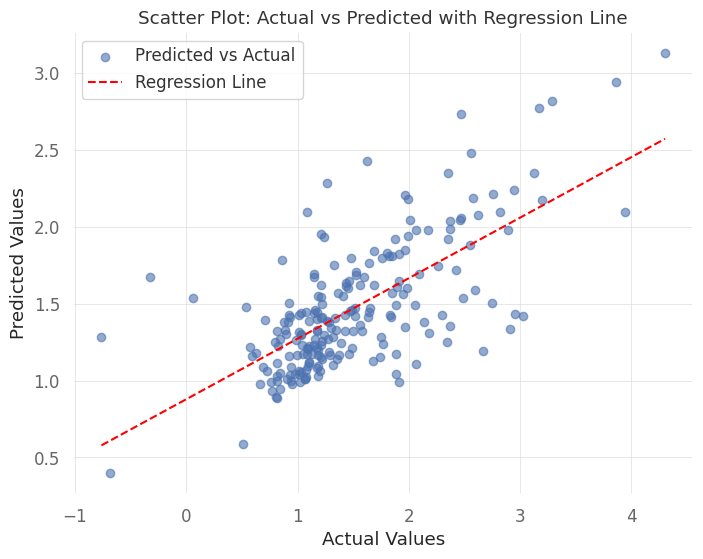

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Ensure y_test and y_pred are numpy arrays
y_test_array = y_test.to_numpy().reshape(-1, 1)  # Convert to 2D array
y_pred_array = y_pred.reshape(-1, 1)  # Ensure y_pred is 2D as well

# Fit a regression line to the scatter data
reg_line = LinearRegression()
reg_line.fit(y_test_array, y_pred_array)  # Fit the regression line
line_x = np.linspace(min(y_test_array), max(y_test_array), 100).reshape(-1, 1)  # Generate X values for line
line_y = reg_line.predict(line_x)  # Predict Y values for the line

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predicted vs Actual")

# Plot the regression line
plt.plot(line_x, line_y, color="red", label="Regression Line", linestyle="--")

# Add labels and legend
plt.title("Scatter Plot: Actual vs Predicted with Regression Line")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()


# select symbols for test

In [9]:
y_pred

array([1.47200917, 1.44499481, 1.04109947, 1.81943009, 1.06274596,
       1.16703272, 1.2330774 , 1.38417791, 2.17133292, 2.23887836,
       2.17938561, 1.08499439, 1.22785183, 1.97685418, 1.62298206,
       1.80989834, 1.62296308, 1.67302124, 1.26940479, 1.74445272,
       1.44314126, 1.61058542, 0.97664915, 1.13675233, 1.36288041,
       1.5462547 , 2.28620131, 1.42516843, 1.9522561 , 1.2296546 ,
       1.0278519 , 0.94257775, 1.06696533, 1.87880933, 1.93787148,
       1.41252313, 1.47005478, 2.93919749, 1.79841071, 1.40956788,
       1.54222494, 1.91789946, 1.50528947, 1.25160333, 1.61806692,
       1.00838703, 1.09517358, 0.88924664, 1.34089171, 2.05432977,
       1.17236623, 0.93404697, 1.42636625, 1.04829402, 1.68478835,
       1.42361279, 1.27998305, 2.3475731 , 1.28250345, 0.99907525,
       1.17356285, 1.29978474, 1.43539367, 1.41574384, 2.76911114,
       1.34805764, 1.63133645, 1.81176295, 1.11293174, 1.251573  ,
       1.7201539 , 3.12712617, 1.33266645, 1.12402684, 1.02347

In [11]:
X_test

,train_max_drawdown_[%],train_max_drawdown_duration,train_win_rate_[%],train_best_trade_[%],train_worst_trade_[%],train_avg_winning_trade_[%],train_avg_losing_trade_[%],train_avg_winning_trade_duration,train_avg_losing_trade_duration,train_profit_factor,...,train_true_precision,train_true_recall,train_true_f1_score,train_accuracy,train_macro avg_precision,train_macro avg_recall,train_macro avg_f1_score,train_weighted avg_precision,train_weighted avg_recall,train_weighted avg_f1_score
751,42.860599,0.635988,66.935484,21.367965,-4.122223,5.306573,-1.560548,9.578313,2.731707,8.745014,...,0.96,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
598,62.912072,0.981417,65.683646,25.408502,-42.915115,4.150974,-2.313046,7.632653,3.171875,4.160977,...,0.92,0.93,0.92,0.94,0.93,0.94,0.94,0.94,0.94,0.94
162,53.339278,0.418415,63.519313,28.678680,-35.912733,3.300890,-2.024583,8.121622,3.448718,4.014227,...,0.90,0.95,0.93,0.95,0.94,0.95,0.94,0.95,0.95,0.95
91,54.748999,0.221374,55.238095,18.081659,-6.442264,3.114612,-1.397419,8.948276,2.478261,2.793046,...,0.95,0.98,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
88,38.266356,0.217986,72.647059,10.367452,-4.636569,2.315507,-0.907811,9.449393,3.347826,5.855560,...,0.92,0.92,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,27.935003,0.331674,66.153846,32.071262,-7.778710,2.686399,-1.433349,7.662791,3.068182,3.657179,...,0.95,0.98,0.96,0.97,0.97,0.97,0.97,0.97,0.97,0.97
315,39.257492,0.335418,69.892473,41.351152,-19.755170,8.476595,-4.490451,7.623077,2.428571,2.191529,...,0.95,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96
48,24.477366,0.727869,49.382716,27.714299,-7.801421,6.478491,-1.739112,8.725000,2.550000,4.033304,...,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98,0.98
274,40.372223,0.515045,61.603376,15.386495,-5.707196,3.003991,-1.192451,7.904110,3.142857,4.821732,...,0.88,0.96,0.92,0.94,0.93,0.95,0.94,0.95,0.94,0.95


In [13]:
df_fin

,train_max_drawdown_[%],train_max_drawdown_duration,train_win_rate_[%],train_best_trade_[%],train_worst_trade_[%],train_avg_winning_trade_[%],train_avg_losing_trade_[%],train_avg_winning_trade_duration,train_avg_losing_trade_duration,train_profit_factor,...,train_true_precision,train_true_recall,train_true_f1_score,train_accuracy,train_macro avg_precision,train_macro avg_recall,train_macro avg_f1_score,train_weighted avg_precision,train_weighted avg_recall,train_weighted avg_f1_score
0,32.842808,0.323245,55.319149,29.411765,-8.695652,4.503891,-1.626228,7.076923,2.803279,2.872888,...,0.94,0.98,0.96,0.97,0.96,0.97,0.97,0.97,0.97,0.97
1,32.095343,0.212505,57.711443,34.033639,-7.347840,4.492853,-1.728899,7.146552,2.987952,2.461184,...,0.92,0.97,0.94,0.96,0.95,0.96,0.95,0.96,0.96,0.96
2,31.871764,0.165587,69.709544,34.033639,-8.695652,3.846482,-1.791416,7.613095,3.408451,5.409532,...,0.92,0.96,0.94,0.95,0.95,0.95,0.95,0.95,0.95,0.95
3,31.956289,0.133086,68.896321,47.899160,-8.808931,3.829873,-1.669257,7.349515,3.200000,4.509006,...,0.91,0.94,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94
4,32.921668,0.111805,67.673716,47.899160,-9.358977,3.718765,-1.572589,8.245536,3.431373,5.106710,...,0.90,0.93,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047,61.077448,0.150085,63.448276,11.879766,-1.636512,0.931519,-0.360271,8.380435,2.849057,4.357045,...,0.95,0.96,0.95,0.96,0.96,0.96,0.96,0.96,0.96,0.96
1048,61.077448,0.106624,65.680473,11.991146,-1.650537,1.084922,-0.389273,10.945946,3.258621,5.857682,...,0.94,0.94,0.94,0.95,0.94,0.95,0.94,0.95,0.95,0.95
1049,61.077448,0.081131,71.304348,11.991146,-1.499235,0.868646,-0.396806,9.914634,3.227273,5.256213,...,0.93,0.94,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94
1050,61.077448,0.073013,69.930070,12.515372,-1.283778,0.845167,-0.325988,9.340000,3.430233,5.686380,...,0.91,0.93,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93


In [16]:
df.loc[y_test.index,'symbol']

751     SLB
598    CSCO
162     XLF
91      MMM
88      VTI
       ... 
710      GL
315    SOXL
48      LUV
274     MDT
30      CVX
Name: symbol, Length: 211, dtype: object

In [23]:
df_pf_symbols = pd.concat([df.loc[y_test.index,'symbol'], y_test, pd.Series(y_pred, index = y_test.index, name = 'test_pred')],
                          axis = 1)
df_pf_symbols

,symbol,test_sharpe_ratio,test_pred
751,SLB,1.651323,1.472009
598,CSCO,1.174150,1.444995
162,XLF,1.014791,1.041099
91,MMM,1.908073,1.819430
88,VTI,0.727197,1.062746
...,...,...,...
710,GL,0.906998,1.012290
315,SOXL,3.025191,1.416757
48,LUV,0.709048,1.395481
274,MDT,1.314761,1.097660


In [29]:
df_pf_symbols['symbol'].nunique()

133

In [30]:
df_pf_symbols.groupby(by = 'symbol')['test_pred']\
    .agg(['count', 'mean', 'median'])\
    .sort_values(by = 'mean', ascending = False)\
    .head(25)

,count,mean,median
symbol,,,
PBR,1,3.127126,3.127126
T,2,2.854154,2.854154
VALE,1,2.476554,2.476554
FTNT,1,2.351755,2.351755
BX,1,2.286201,2.286201
MO,4,2.212806,2.265000
NVDA,1,2.209271,2.209271
TNA,1,2.206121,2.206121
BSX,1,2.171333,2.171333
